# Exploratory Data Analysis

In [1]:
# data science
from scipy.stats import norm
import numpy as np
import sqlite3 as sql
import pandas as pd
from collections import defaultdict, Counter

# utilities
from pathlib import Path
from termcolor import colored
from tqdm import tqdm
import gzip
import math
import os
from dotenv import load_dotenv

# plotting
import matplotlib.pyplot as plt 
import seaborn as sns

# LOAD ENVIRONMENT
load_dotenv("paths.env")
DATABASE = os.getenv("DATABASE")

assert os.path.isdir(DATABASE), "Invalid directory!"

In [2]:
domains = ["Archaea", "Eukaryota", "Bacteria", "Viruses"]
domain_colors = {
                'Viruses': '#b2ebeb',
                'Eukaryota': '#ffb2b2',
                'Archaea': '#b2b2ff',
                'Bacteria': '#b2d8b2'
                }

In [26]:
irp_df = pd.read_csv("/storage/group/izg5139/default/nicole/inverted_repeats/paper_data/irp_database_new.csv.gz")
irp_df.shape


/tmp/ipykernel_243009/3784955186.py:1: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  irp_df = pd.read_csv("/storage/group/izg5139/default/nicole/inverted_repeats/paper_data/irp_database_new.csv.gz")


(24146010, 25)

In [17]:
empty_assemblies = pd.read_csv("/storage/group/izg5139/default/nicole/inverted_repeats/paper_data/empty_assemblies.csv.gz")
print(empty_assemblies.shape)
empty_assemblies.head()

(30876, 18)


,#assembly_accession,bioproject,taxid,species_taxid,organism_name,assembly_level,group,genome_size,gc_percent,total_gene_count,assembly_id,method,tax_id,order,class,phylum,kingdom,superkingdom
0,GCA_003083255.1,na,48295,40050,African horse sickness virus 2,Complete Genome,viral,19530,42.5,10,G003083255,GCA,48295.0,Reovirales,Resentoviricetes,Duplornaviricota,Orthornavirae,Viruses
1,GCF_013426655.1,na,2753656,2753656,Proteus phage ASh-2020a,Complete Genome,viral,59078,46.5,68,G013426655,GCF,2753656.0,NaN,Caudoviricetes,Uroviricota,Heunggongvirae,Viruses
2,GCA_003097935.1,na,540992,11676,HIV-1 CRF04_cpx,Complete Genome,viral,9050,42.0,9,G003097935,GCA,540992.0,Ortervirales,Revtraviricetes,Artverviricota,Pararnavirae,Viruses
3,GCF_004117395.1,na,1907787,1907787,Picobirnavirus sp.,Complete Genome,viral,4297,40.5,4,G004117395,GCF,1907787.0,Durnavirales,Duplopiviricetes,Pisuviricota,Orthornavirae,Viruses
4,GCA_031202795.1,na,2740144,2740144,Brassica caulorapa potyvirus,Complete Genome,viral,9433,42.5,na,G031202795,GCA,2740144.0,Patatavirales,Stelpaviricetes,Pisuviricota,Orthornavirae,Viruses


In [18]:
def add_empty_assemblies(df):
    global empty_assemblies
    return pd.concat([df, empty_assemblies.set_index("#assembly_accession")[["superkingdom"]]], axis=0)

In [19]:
def decompose_kmer(kmer, kmer_length):
    if kmer_length == 1:
        return dict(Counter(kmer))
    kmer_counts = defaultdict(int)
    for i in range(len(kmer) - kmer_length + 1):
        kmer_slice = kmer[i: i+kmer_length]
        if all(n == 'a' or n == 't' or n == 'c' or n == 'g' for n in kmer_slice):
            kmer_counts[kmer_slice] += 1
            
    return dict(kmer_counts)

In [4]:
def decompose_sequences(irp_df, kmer_length):
    decomposed_kmers = []
    for _, row in tqdm(irp_df.iterrows(), leave=True, position=0, total=irp_df.shape[0]):
        inverted_repeat = row["sequenceof_arm"]
        kmer_decomposition = decompose_kmer(inverted_repeat, kmer_length)
        kmer_decomposition = {**kmer_decomposition, **decompose_kmer(inverted_repeat, kmer_length+1)}
        kmer_decomposition.update({
                                   "#assembly_accession": row["#assembly_accession"],
                                   "arm_size": len(inverted_repeat), 
                                   "superkingdom": row["superkingdom"], 
                                   "kingdom": row["kingdom"],
                                   "phylum": row["phylum"],
                                   "species_taxid": row["species_taxid"],
                                    "sequenceof_arm": row["sequenceof_arm"],
                                    "genome_size": row["genome_size"],
                                    "gc_percent": row["gc_percent"],
                                   "gap_size": row["gap_size"]
                                  })
        decomposed_kmers.append(kmer_decomposition)
        
    decomposed_kmers = pd.DataFrame(decomposed_kmers).fillna(0.0)
    return decomposed_kmers.set_index("#assembly_accession")

In [7]:
!echo $DATABASE

/storage/group/izg5139/default/nicole/inverted_repeats/paper_graphs/final_figures


In [11]:
kmer_length =  1
path = f"{DATABASE}/decomposed_kmers_irp.csv.gz"

if os.path.isfile(path):
    decomposed_kmers = pd.read_csv(f"{DATABASE}/decomposed_kmers_irp.csv.gz")
else:
    decomposed_kmers = decompose_sequences(irp_df, kmer_length)
    decomposed_kmers.loc[:, "gc_content"] = decomposed_kmers["g"] + decomposed_kmers["c"]
    decomposed_kmers.loc[:, "ta_content"] = decomposed_kmers["t"] + decomposed_kmers["a"]
    decomposed_kmers.to_csv(f"{DATABASE}/decomposed_kmers_irp.csv.gz", mode="w", index=True, compression="gzip")

decomposed_kmers

,#assembly_accession,a,t,g,at,tg,gt,ta,arm_size,superkingdom,...,aa,ca,ag,gc,ac,cg,cc,gg,gc_content,ta_content
0,GCF_000002515.2,5.0,5.0,1.0,4.0,1.0,1.0,4.0,11,Eukaryota,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,10.0
1,GCF_000002515.2,4.0,4.0,2.0,2.0,1.0,0.0,1.0,11,Eukaryota,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,8.0
2,GCF_000002515.2,1.0,7.0,0.0,1.0,0.0,0.0,0.0,10,Eukaryota,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,8.0
3,GCF_000002515.2,6.0,4.0,2.0,2.0,0.0,0.0,2.0,14,Eukaryota,...,2.0,1.0,2.0,2.0,0.0,0.0,0.0,0.0,4.0,10.0
4,GCF_000002515.2,10.0,4.0,6.0,1.0,2.0,2.0,0.0,24,Eukaryota,...,3.0,3.0,3.0,1.0,2.0,1.0,0.0,0.0,10.0,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24146005,GCF_031844645.1,1.0,3.0,5.0,1.0,1.0,1.0,0.0,11,Bacteria,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,7.0,4.0
24146006,GCF_031844645.1,2.0,2.0,6.0,1.0,1.0,1.0,0.0,13,Bacteria,...,0.0,1.0,1.0,2.0,0.0,2.0,0.0,2.0,9.0,4.0
24146007,GCF_031844645.1,3.0,1.0,3.0,1.0,1.0,0.0,0.0,12,Bacteria,...,1.0,1.0,0.0,2.0,1.0,1.0,2.0,1.0,8.0,4.0
24146008,GCF_031844645.1,8.0,3.0,2.0,2.0,1.0,1.0,0.0,15,Bacteria,...,5.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,4.0,11.0


In [12]:
for col in decomposed_kmers.columns:
    if len(col) <= 2 or col.startswith("gc_") or col.startswith("ta_"):
        decomposed_kmers[col] = decomposed_kmers[col].astype(int)

# Investigating the Poly-A Phenomenon

In [13]:
decomposed_kmers

,#assembly_accession,a,t,g,at,tg,gt,ta,arm_size,superkingdom,...,aa,ca,ag,gc,ac,cg,cc,gg,gc_content,ta_content
0,GCF_000002515.2,5,5,1,4,1,1,4,11,Eukaryota,...,0,0,0,0,0,0,0,0,1,10
1,GCF_000002515.2,4,4,2,2,1,0,1,11,Eukaryota,...,1,0,0,0,0,0,0,0,3,8
2,GCF_000002515.2,1,7,0,1,0,0,0,10,Eukaryota,...,0,1,0,0,0,0,0,0,2,8
3,GCF_000002515.2,6,4,2,2,0,0,2,14,Eukaryota,...,2,1,2,2,0,0,0,0,4,10
4,GCF_000002515.2,10,4,6,1,2,2,0,24,Eukaryota,...,3,3,3,1,2,1,0,0,10,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24146005,GCF_031844645.1,1,3,5,1,1,1,0,11,Bacteria,...,0,0,0,0,0,1,1,2,7,4
24146006,GCF_031844645.1,2,2,6,1,1,1,0,13,Bacteria,...,0,1,1,2,0,2,0,2,9,4
24146007,GCF_031844645.1,3,1,3,1,1,0,0,12,Bacteria,...,1,1,0,2,1,1,2,1,8,4
24146008,GCF_031844645.1,8,3,2,2,1,1,0,15,Bacteria,...,5,2,1,0,0,0,0,0,4,11


In [14]:
decomposed_kmers = decomposed_kmers.query("superkingdom != 'Other/Non-specified'")
decomposed_kmers.shape

(24120989, 32)

# Group by GC-TA Content Proportion per Domain (for barplot)

In [15]:
decomposed_kmers.loc[:, "gc_content_prop"] = decomposed_kmers["gc_content"].div(decomposed_kmers["arm_size"])
decomposed_kmers.loc[:, "ta_content_prop"] = decomposed_kmers["ta_content"].div(decomposed_kmers["arm_size"])

/tmp/ipykernel_243009/3488535727.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  decomposed_kmers.loc[:, "gc_content_prop"] = decomposed_kmers["gc_content"].div(decomposed_kmers["arm_size"])
/tmp/ipykernel_243009/3488535727.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  decomposed_kmers.loc[:, "ta_content_prop"] = decomposed_kmers["ta_content"].div(decomposed_kmers["arm_size"])


In [16]:
decomposed_kmers.head()

,#assembly_accession,a,t,g,at,tg,gt,ta,arm_size,superkingdom,...,ag,gc,ac,cg,cc,gg,gc_content,ta_content,gc_content_prop,ta_content_prop
0,GCF_000002515.2,5,5,1,4,1,1,4,11,Eukaryota,...,0,0,0,0,0,0,1,10,0.090909,0.909091
1,GCF_000002515.2,4,4,2,2,1,0,1,11,Eukaryota,...,0,0,0,0,0,0,3,8,0.272727,0.727273
2,GCF_000002515.2,1,7,0,1,0,0,0,10,Eukaryota,...,0,0,0,0,0,0,2,8,0.200000,0.800000
3,GCF_000002515.2,6,4,2,2,0,0,2,14,Eukaryota,...,2,2,0,0,0,0,4,10,0.285714,0.714286
4,GCF_000002515.2,10,4,6,1,2,2,0,24,Eukaryota,...,3,1,2,1,0,0,10,14,0.416667,0.583333


In [17]:
df_segmented_kingdom = decomposed_kmers.query("phylum != 0.0")\
                                       .groupby(["kingdom", "arm_size"], as_index=False)\
                                             .agg({"gc_content": "sum", 
                                                   "ta_content": "sum",
                                                   "t": "count"}
                                                  )\
                                             .rename(columns={"t": "total_counts", "gc_content": "gc", "ta_content": "ta"})
df_segmented_kingdom.loc[:, "gc"] = df_segmented_kingdom["gc"].div(df_segmented_kingdom["arm_size"] * df_segmented_kingdom["total_counts"])
df_segmented_kingdom.loc[:, "ta"] = df_segmented_kingdom["ta"].div(df_segmented_kingdom["arm_size"] * df_segmented_kingdom["total_counts"])
    
# p = calculate_gc_ta_segmentation(df_segmented.query("arm_size < 30"), domain, idx)
df_segmented_kingdom

,kingdom,arm_size,gc,ta,total_counts
0,0.0,10,0.433333,0.566667,6
1,0.0,11,0.454545,0.545455,3
2,0.0,12,0.500000,0.500000,1
3,Animalia,10,0.193111,0.806889,311649
4,Animalia,11,0.188535,0.811465,168380
...,...,...,...,...,...
1316,Zilligvirae,10,0.158065,0.841935,31
1317,Zilligvirae,11,0.121212,0.878788,3
1318,Zilligvirae,12,0.166667,0.833333,4
1319,Zilligvirae,13,0.179487,0.820513,3


In [18]:
df_segmented = decomposed_kmers.query("phylum != 0.0")\
                              .groupby(["superkingdom", "arm_size"], as_index=False)\
                                             .agg({"gc_content": "sum", 
                                                   "ta_content": "sum",
                                                   "t": "count"}
                                                  )\
                                             .rename(columns={"t": "total_counts", "gc_content": "gc", "ta_content": "ta"})
df_segmented.loc[:, "gc"] = df_segmented["gc"].div(df_segmented["arm_size"] * df_segmented["total_counts"])
df_segmented.loc[:, "ta"] = df_segmented["ta"].div(df_segmented["arm_size"] * df_segmented["total_counts"])
    
# p = calculate_gc_ta_segmentation(df_segmented.query("arm_size < 30"), domain, idx)
df_segmented

,superkingdom,arm_size,gc,ta,total_counts
0,Archaea,10,0.563300,0.436700,50798
1,Archaea,11,0.567373,0.432627,18760
2,Archaea,12,0.581372,0.418628,8964
3,Archaea,13,0.636978,0.363022,5055
4,Archaea,14,0.637746,0.362254,2893
...,...,...,...,...,...
845,Viruses,3886,0.597272,0.402728,1
846,Viruses,3941,0.480589,0.519411,1
847,Viruses,4105,0.593666,0.406334,1
848,Viruses,9338,0.266438,0.733562,1


In [ ]:
df_segmented_kingdoms.to_csv(f"{DATABASE}/gc_vs_ta_content_kingdoms_per_arm.csv", mode="w", index=False)
df_segmented.to_csv(f"{DATABASE}/gc_vs_ta_content_domains_per_arm.csv", mode="w", index=False)

# Streamplot Inverted  Repeat Dinucleotide Analysis

In [95]:
decomposed_kmers

,a,t,g,at,tg,gt,ta,arm_size,superkingdom,kingdom,...,gc_content,ta_content,a_prop,g_prop,c_prop,t_prop,at_enrichment,gc_enrichment,gc_content_prop,ta_content_prop
#assembly_accession,,,,,,,,,,,,,,,,,,,,,
GCF_000002515.2,5,5,1,4,1,1,4,11,Eukaryota,Fungi,...,1,10,0.454545,0.090909,0.000000,0.454545,0.500000,1.000000,0.090909,0.909091
GCF_000002515.2,4,4,2,2,1,0,1,11,Eukaryota,Fungi,...,3,8,0.363636,0.181818,0.090909,0.363636,0.500000,0.666667,0.272727,0.727273
GCF_000002515.2,1,7,0,1,0,0,0,10,Eukaryota,Fungi,...,2,8,0.100000,0.000000,0.200000,0.700000,0.125000,0.000000,0.200000,0.800000
GCF_000002515.2,6,4,2,2,0,0,2,14,Eukaryota,Fungi,...,4,10,0.428571,0.142857,0.142857,0.285714,0.600000,0.500000,0.285714,0.714286
GCF_000002515.2,10,4,6,1,2,2,0,24,Eukaryota,Fungi,...,10,14,0.416667,0.250000,0.166667,0.166667,0.714286,0.600000,0.416667,0.583333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GCF_031844645.1,1,3,5,1,1,1,0,11,Bacteria,Eubacteria,...,7,4,0.090909,0.454545,0.181818,0.272727,0.250000,0.714286,0.636364,0.363636
GCF_031844645.1,2,2,6,1,1,1,0,13,Bacteria,Eubacteria,...,9,4,0.153846,0.461538,0.230769,0.153846,0.500000,0.666667,0.692308,0.307692
GCF_031844645.1,3,1,3,1,1,0,0,12,Bacteria,Eubacteria,...,8,4,0.250000,0.250000,0.416667,0.083333,0.750000,0.375000,0.666667,0.333333


In [101]:
dinucleotide_colors = {"cc": "crimson",
                       "gg": "green",
                       "gt": "darkgreen",
                       "tg": "gold",
                       "ct": "maroon",
                       "tc": "magenta",
                       "gc": "orange",
                       "cg": "purple",
                       "tt": "lightgreen",
                       "ta": "navy",
                       "at": "pink",
                       "aa": "lightblue",
                       "ag": "yellow",
                       "ga": "blue",
                       "ac": "gray",
                       "ca": "black"
                       }

In [105]:
dinucleotide_composition = temp.groupby(["superkingdom", "arm_size"], as_index=False).agg({dinu: "sum" for dinu in dinucleotide_colors} | {"phylum": "count"})\
                            .rename(columns={'phylum': 'total_occurrences'})
dinucleotide_composition.loc[:, "total_dinucleotides"] = (dinucleotide_composition["arm_size"] - 1) * dinucleotide_composition["total_occurrences"]
dinucleotide_composition.drop(columns=['total_occurrences'], inplace=True)
dinucleotide_composition

,superkingdom,arm_size,cc,gg,gt,tg,ct,tc,gc,cg,tt,ta,at,aa,ag,ga,ac,ca,total_dinucleotides
0,Archaea,10,28221,28819,24642,13618,18277,36643,37579,66616,30885,19214,25970,31335,18979,36994,25141,14249,457182
1,Archaea,11,11913,12854,9228,5756,7569,13879,16526,26667,12366,7990,10678,12771,8518,15250,10057,5578,187600
2,Archaea,12,5940,7787,5007,3513,4475,7121,9434,13023,6229,3827,5294,5770,4967,8154,4887,3176,98604
3,Archaea,13,5109,4997,3697,2019,2623,5285,6634,9137,2819,1854,2889,2875,2634,4017,2276,1795,60660
4,Archaea,14,2817,2588,2136,966,1982,3444,3950,6104,1519,1026,1320,1614,1881,3137,2042,1083,37609
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
845,Viruses,3886,220,346,287,285,230,280,398,442,231,114,161,144,164,206,186,191,3885
846,Viruses,3941,207,244,188,251,201,224,296,247,321,221,306,299,216,230,209,280,3940
847,Viruses,4105,234,355,297,301,246,296,418,464,265,112,166,159,174,224,195,198,4104
848,Viruses,9338,177,169,431,532,421,598,125,140,1503,961,1238,1270,392,508,355,517,9337


In [118]:
# sum reverse complements

dinucleotide_composition.loc[:, "CC"] = dinucleotide_composition["cc"] + dinucleotide_composition["gg"]
dinucleotide_composition.loc[:, "AA"] = dinucleotide_composition["aa"] + dinucleotide_composition["tt"]
dinucleotide_composition.loc[:, "CA"] = dinucleotide_composition["ca"] + dinucleotide_composition["tg"]
dinucleotide_composition.loc[:, "AC"] = dinucleotide_composition["ac"] + dinucleotide_composition["gt"]
dinucleotide_composition.loc[:, "CT"] = dinucleotide_composition["ct"] + dinucleotide_composition["ag"]
dinucleotide_composition.loc[:, "TC"] = dinucleotide_composition["tc"] + dinucleotide_composition["ga"]

# REMAINING DINUCLEOTIDES
# TA 
# AT
# GC
# CG

dinucleotide_composition.loc[:, "TA"] = dinucleotide_composition["ta"] 
dinucleotide_composition.loc[:, "AT"] = dinucleotide_composition["at"] 
dinucleotide_composition.loc[:, "GC"] = dinucleotide_composition["gc"] 
dinucleotide_composition.loc[:, "CG"] = dinucleotide_composition["cg"] 

remaining_dinus = {"TA", "AT", "GC", "CG", "CC", "AA", "CA", "AC", "CT", "TC"}
dinucleotide_composition_rc = dinucleotide_composition[[dinu for dinu in remaining_dinus] + ["superkingdom", "arm_size", "total_dinucleotides"]]
for dinu in remaining_dinus:
    dinucleotide_composition_rc.loc[:, f"{dinu}_prop"] = dinucleotide_composition_rc[dinu].div(dinucleotide_composition_rc["total_dinucleotides"])

dinucleotide_composition_rc.drop(columns=['total_dinucleotides'], inplace=True)
dinucleotide_composition_rc = dinucleotide_composition_rc[[f"{dinu}_prop" for dinu in remaining_dinus] + ["superkingdom", "arm_size"]]
dinucleotide_composition_rc[[f"{dinu}_prop" for dinu in remaining_dinus]].apply(lambda probability_vector: probability_vector.sum(), axis=1)

/tmp/ipykernel_3539646/357310864.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dinucleotide_composition_rc.loc[:, f"{dinu}_prop"] = dinucleotide_composition_rc[dinu].div(dinucleotide_composition_rc["total_dinucleotides"])
/tmp/ipykernel_3539646/357310864.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dinucleotide_composition_rc.loc[:, f"{dinu}_prop"] = dinucleotide_composition_rc[dinu].div(dinucleotide_composition_rc["total_dinucleotides"])
/tmp/ipykernel_3539646/357310864.py:24: SettingWithCop

0      1.0
1      1.0
2      1.0
3      1.0
4      1.0
      ... 
845    1.0
846    1.0
847    1.0
848    1.0
849    1.0
Length: 850, dtype: float64

In [119]:
dinucleotide_composition_rc

,TA_prop,CG_prop,CA_prop,AA_prop,AC_prop,CC_prop,AT_prop,GC_prop,CT_prop,TC_prop,superkingdom,arm_size
0,0.042027,0.145710,0.060954,0.136095,0.108891,0.124764,0.056805,0.082197,0.081491,0.161067,Archaea,10
1,0.042591,0.142148,0.060416,0.133993,0.102799,0.132020,0.056919,0.088092,0.085752,0.155272,Archaea,11
2,0.038812,0.132074,0.067837,0.121689,0.100341,0.139213,0.053690,0.095676,0.095757,0.154913,Archaea,12
3,0.030564,0.150626,0.062875,0.093867,0.098467,0.166601,0.047626,0.109364,0.086663,0.153347,Archaea,13
4,0.027281,0.162302,0.054482,0.083305,0.111090,0.143716,0.035098,0.105028,0.102715,0.174985,Archaea,14
...,...,...,...,...,...,...,...,...,...,...,...,...
845,0.029344,0.113771,0.122523,0.096525,0.121750,0.145689,0.041441,0.102445,0.101416,0.125097,Viruses,3886
846,0.056091,0.062690,0.134772,0.157360,0.100761,0.114467,0.077665,0.075127,0.105838,0.115228,Viruses,3941
847,0.027290,0.113060,0.121589,0.103314,0.119883,0.143519,0.040448,0.101852,0.102339,0.126706,Viruses,4105
848,0.102924,0.014994,0.112349,0.296990,0.084181,0.037057,0.132591,0.013388,0.087073,0.118453,Viruses,9338


In [120]:
dinucleotide_composition_rc.to_csv(f"{DATABASE}/dinucleotide_stream_domain_arm_size.csv", index=False, mode="w")

# Nucleotide Composition Analysis (First Arm)

In [29]:
for nucleotide in ["a", "g", "c", "t"]:
        decomposed_kmers.loc[:, f"{nucleotide}_prop"] = decomposed_kmers[nucleotide].div(decomposed_kmers["arm_size"])
    
decomposed_kmers.loc[:, "at_enrichment"] = decomposed_kmers["a"] / (decomposed_kmers["t"] + decomposed_kmers["a"])
decomposed_kmers.loc[:, "gc_enrichment"] = decomposed_kmers["g"] / (decomposed_kmers["g"] + decomposed_kmers["c"])

/tmp/ipykernel_4033275/136384531.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  decomposed_kmers.loc[:, f"{nucleotide}_prop"] = decomposed_kmers[nucleotide].div(decomposed_kmers["arm_size"])
/tmp/ipykernel_4033275/136384531.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  decomposed_kmers.loc[:, f"{nucleotide}_prop"] = decomposed_kmers[nucleotide].div(decomposed_kmers["arm_size"])
/tmp/ipykernel_4033275/136384531.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

In [30]:
arm_10_sequences = decomposed_kmers.query(f"at_enrichment < {float('inf')} & gc_enrichment < {float('inf')}").query("arm_size == 10")

aggregated_nucleotide_counts = decomposed_kmers.groupby(decomposed_kmers.index)\
                            .agg({"a_prop": "mean", 
                                  "t_prop": "mean", 
                                  "c_prop": "mean", 
                                  "g_prop": "mean", 
                                  # "at_enrichment": "mean",
                                  # "gc_enrichment": "mean",
                                  "superkingdom": "first", 
                                  "phylum": "first", 
                                  "kingdom": "first",
                                  "genome_size": "first"
                                 }
                                )\
            .assign(total=lambda df: df[[f"{col}_prop" for col in {'a', 'c', 'g', 't'}]].sum(axis=1))

# for col in [col for col in aggregated_nucleotide_counts.columns if len(col) ==1]:
#    aggregated_nucleotide_counts.loc[:, f"{col}_prop"] = aggregated_nucleotide_counts[col].div(aggregated_nucleotide_counts['total'])
    
aggregated_nucleotide_counts

,a_prop,t_prop,c_prop,g_prop,superkingdom,phylum,kingdom,genome_size,total
#assembly_accession,,,,,,,,,
GCA_000006845.1,0.323237,0.208505,0.241745,0.226513,Bacteria,Pseudomonadota,Eubacteria,2153922,1.0
GCA_000006865.1,0.472379,0.258524,0.147935,0.121162,Bacteria,Bacillota,Eubacteria,2365589,1.0
GCA_000006925.2,0.300432,0.194038,0.263231,0.242299,Bacteria,Pseudomonadota,Eubacteria,4828820,1.0
GCA_000007025.1,0.444546,0.323824,0.136426,0.095204,Bacteria,Pseudomonadota,Eubacteria,1268755,1.0
GCA_000007085.1,0.376452,0.235922,0.173313,0.214313,Bacteria,Bacillota,Eubacteria,2689445,1.0
...,...,...,...,...,...,...,...,...,...
GCF_963422545.1,0.396315,0.289768,0.177235,0.136682,Bacteria,Bacteroidota,Eubacteria,5236164,1.0
GCF_963457545.1,0.385870,0.393886,0.118089,0.102155,Archaea,Nitrososphaerota,Archaeabacteria,2359279,1.0
GCF_963457575.1,0.151847,0.109724,0.378276,0.360154,Bacteria,Pseudomonadota,Eubacteria,4103361,1.0


In [31]:
aggregated_nucleotide_counts.query("superkingdom == 'Eukaryota'")

,a_prop,t_prop,c_prop,g_prop,superkingdom,phylum,kingdom,genome_size,total
#assembly_accession,,,,,,,,,
GCA_000143535.4,0.409634,0.437885,0.077048,0.075433,Eukaryota,Ascomycota,Fungi,42630066,1.0
GCA_000292605.2,0.311308,0.385270,0.163368,0.140054,Eukaryota,Ascomycota,Fungi,43237743,1.0
GCA_000400815.2,0.343911,0.379160,0.146350,0.130580,Eukaryota,Ascomycota,Fungi,36150287,1.0
GCA_000412225.2,0.208977,0.208459,0.292589,0.289976,Eukaryota,Ascomycota,Fungi,8867527,1.0
GCA_000613145.2,0.365254,0.350698,0.156745,0.127303,Eukaryota,Ascomycota,Fungi,20090583,1.0
...,...,...,...,...,...,...,...,...,...
GCF_030864355.1,0.199310,0.189559,0.304723,0.306408,Eukaryota,Basidiomycota,Fungi,20237334,1.0
GCF_900002385.2,0.489409,0.471973,0.019186,0.019431,Eukaryota,Apicomplexa,Protista,23043114,1.0
GCF_900681995.1,0.485166,0.466277,0.024207,0.024349,Eukaryota,Apicomplexa,Protista,18338688,1.0


/storage/group/izg5139/default/nicole/miniconda3/lib/python3.11/site-packages/seaborn/matrix.py:659: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


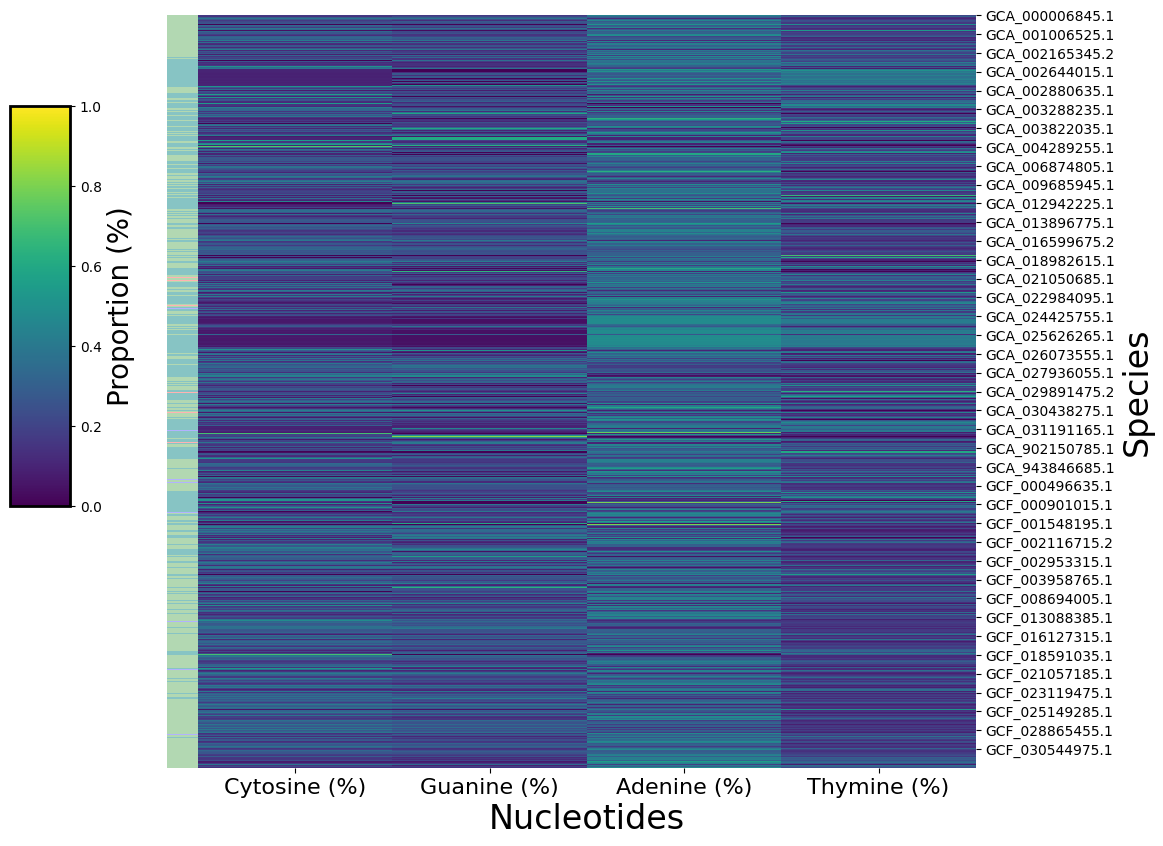

In [30]:
row_colors = [domain_colors[domain] for domain in aggregated_nucleotide_counts.superkingdom]
cg = sns.clustermap(aggregated_nucleotide_counts[["a_prop", "c_prop", "g_prop", "t_prop"]]\
                                                 .rename(columns={"c_prop": "Cytosine (%)",
                                                                    "g_prop": "Guanine (%)",
                                                                    "a_prop": "Adenine (%)",
                                                                    "t_prop": "Thymine (%)"
                                                                   }
                                                          ),
                    row_colors=row_colors, 
                    figsize=(12, 10),
                    # vmax=0.037,
                    # vmin=0.00,
                    cmap="viridis", #sns.cubehelix_palette(as_cmap=True, start=25), 
                    row_cluster=False,  
                    cbar_kws={"orientation": "vertical",
                              "label": "Proportion (%)"}
            )

x0, _y0, _w, _h = cg.cbar_pos
cg.ax_cbar.set_position([0.05, 0.3, 0.05, 0.4])
# cg.ax_cbar.set_title('Proportion (%)')
cg.ax_cbar.tick_params(axis='x', length=10)
for spine in cg.ax_cbar.spines:
    # g.ax_cbar.spines[spine].set_color('crimson')
    cg.ax_cbar.spines[spine].set_linewidth(2)

cg.ax_row_dendrogram.set_visible(False)
cg.ax_col_dendrogram.set_visible(False)
ax = cg.ax_heatmap
# cbar_axes = ax.figure.axes[-1]
ax.figure.axes[-1].yaxis.label.set_size(20)
# ax.figure.axes[-1].tick_params(axis="both", which="major", labelsize=18)
cg.ax_heatmap.set_xticklabels(cg.ax_heatmap.get_xmajorticklabels(), fontsize = 16)

ax.set_xlabel('Nucleotides')
ax.set_ylabel("Species")
ax.yaxis.label.set_size(24)
ax.xaxis.label.set_size(24)

In [31]:
melted_decomposition = pd.melt(decomposed_kmers[["superkingdom"] + [f"{nucleotide}_prop" for nucleotide in ["a", "g", "c", "t"]]].reset_index(), 
                             ["#assembly_accession", "superkingdom"],
                            var_name="nucleotide", 
                             value_name="proportion")
melted_decomposition.head()

,#assembly_accession,superkingdom,nucleotide,proportion
0,GCF_000002515.2,Eukaryota,a_prop,0.454545
1,GCF_000002515.2,Eukaryota,a_prop,0.363636
2,GCF_000002515.2,Eukaryota,a_prop,0.100000
3,GCF_000002515.2,Eukaryota,a_prop,0.428571
4,GCF_000002515.2,Eukaryota,a_prop,0.416667


In [32]:
melted_aggregation = pd.melt(aggregated_nucleotide_counts[["superkingdom"] + [f"{nucleotide}_prop" for nucleotide in ["a", "g", "c", "t"]]].reset_index(), 
                             ["#assembly_accession", "superkingdom"],
                            var_name="nucleotide", 
                             value_name="proportion")
melted_aggregation.head()

,#assembly_accession,superkingdom,nucleotide,proportion
0,GCA_000006845.1,Bacteria,a_prop,0.323237
1,GCA_000006865.1,Bacteria,a_prop,0.472379
2,GCA_000006925.2,Bacteria,a_prop,0.300432
3,GCA_000007025.1,Bacteria,a_prop,0.444546
4,GCA_000007085.1,Bacteria,a_prop,0.376452


In [33]:
aggregated_nucleotide_counts.query("superkingdom == 'Viruses' & g_prop > 0.9")

,a_prop,t_prop,c_prop,g_prop,superkingdom,phylum,kingdom,genome_size,total
#assembly_accession,,,,,,,,,
GCA_012937225.1,0.0,0.0,0.000000,1.000000,Viruses,Uroviricota,Heunggongvirae,35918,1.0
GCA_031199885.1,0.0,0.0,0.090909,0.909091,Viruses,0.0,Unclassified Viruses,2529,1.0
GCF_018591165.1,0.0,0.0,0.090909,0.909091,Viruses,0.0,Unclassified Viruses,2510,1.0


/storage/group/izg5139/default/nicole/miniconda3/lib/python3.11/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/storage/group/izg5139/default/nicole/miniconda3/lib/python3.11/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/storage/group/izg5139/default/nicole/miniconda3/lib/python3.11/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


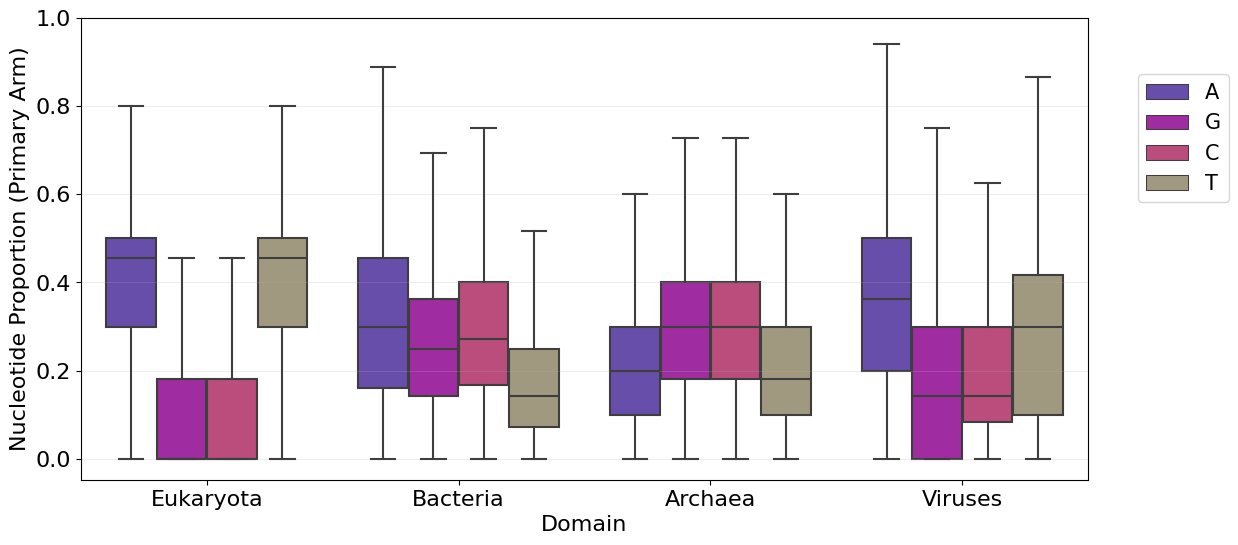

In [43]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(13, 6))
ax.grid(lw=0.4, alpha=0.4, zorder=0)
sns.boxplot(data=melted_decomposition, 
            palette={"a_prop": "#603fba",
                     "g_prop": "#b218b5",
                     "c_prop": "#cc3b78",
                     "t_prop": "#a69a7b"
                    },
            x="superkingdom", 
            y="proportion",
            hue="nucleotide",
            showfliers=False,
            zorder=3,
            ax=ax)
ax.set_xlabel("Domain")
ax.xaxis.label.set_size(16)
ax.set_ylabel("Nucleotide Proportion (Primary Arm)")
ax.yaxis.label.set_size(16)
ax.set_ylim(ymax=1.0)
handles, previous_labels = ax.get_legend_handles_labels()
ax.legend(prop={"size": 15}, 
          handles=handles, 
          labels=[prev.split('_')[0].upper() for prev in previous_labels],
          title="", 
          fancybox=True, 
          frameon=True, 
          bbox_to_anchor=(1.15, 0.9))

ax.tick_params(axis="both", which="major", labelsize=16)
fig.savefig(f"{DATABSE}/primary_arm_nucleotide_composition_all.png", bbox_inches='tight')

/storage/group/izg5139/default/nicole/miniconda3/lib/python3.11/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/storage/group/izg5139/default/nicole/miniconda3/lib/python3.11/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/storage/group/izg5139/default/nicole/miniconda3/lib/python3.11/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


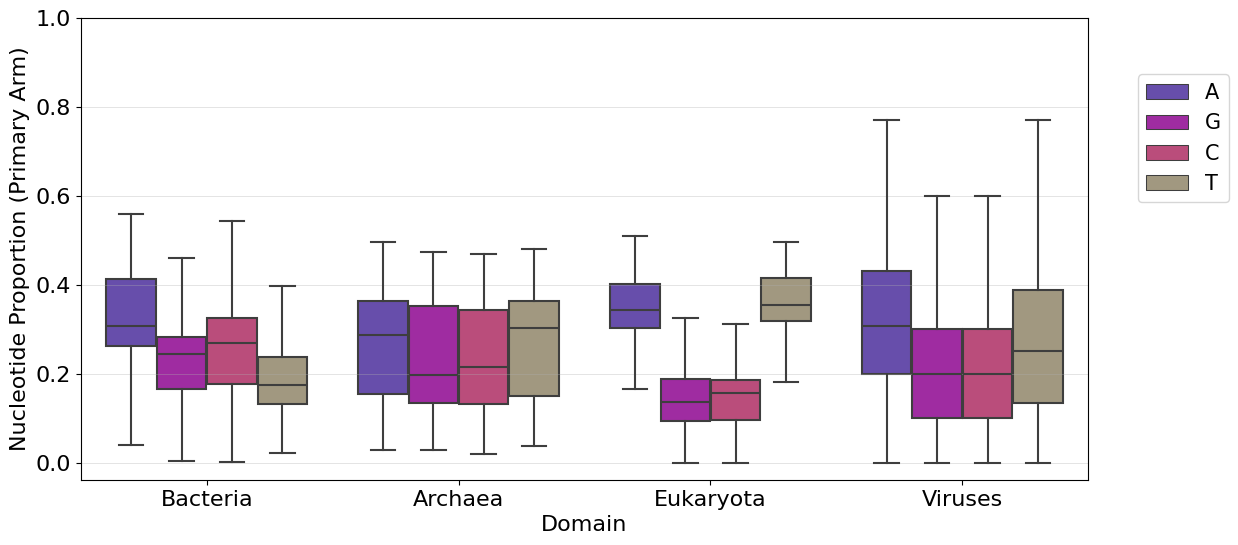

In [41]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(13, 6))
ax.grid(lw=0.4, alpha=0.6, zorder=0)
sns.boxplot(data=melted_aggregation, 
            palette={"a_prop": "#603fba",
                     "g_prop": "#b218b5",
                     "c_prop": "#cc3b78",
                     "t_prop": "#a69a7b"
                    },
            x="superkingdom", 
            y="proportion",
            hue="nucleotide",
            showfliers=False,
            zorder=3,
            ax=ax)
ax.set_xlabel("Domain")
ax.xaxis.label.set_size(16)
ax.set_ylabel("Nucleotide Proportion (Primary Arm)")
ax.yaxis.label.set_size(16)
ax.set_ylim(ymax=1.0)
handles, previous_labels = ax.get_legend_handles_labels()
ax.legend(prop={"size": 15}, 
          handles=handles, 
          labels=[prev.split('_')[0].upper() for prev in previous_labels],
          title="", 
          fancybox=True, 
          frameon=True, 
          bbox_to_anchor=(1.15, 0.9))

ax.tick_params(axis="both", which="major", labelsize=16)
fig.savefig(f"{DATABASE}/primary_arm_nucleotide_composition.png", bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
sns.boxplot(data=aggregated_nucleotide_counts, palette=domain_colors, x="superkingdom", y="at_enrichment", ax=ax)
ax.set_xlabel("Domain")
ax.xaxis.label.set_size(22)
ax.set_ylabel("A/T enrichment")
ax.yaxis.label.set_size(22)
ax.tick_params(axis="both", which="major", labelsize=16)
ax.grid(lw=0.4, alpha=0.6, zorder=0)

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
# ax.axhline(0.5, linestyle='--', lw=4.0, color='gray', zorder=0)
sns.boxplot(data=aggregated_nucleotide_counts, palette=domain_colors, zorder=3, x="superkingdom", y="gc_enrichment", ax=ax)
ax.set_xlabel("Domain")
ax.xaxis.label.set_size(22)
ax.set_ylabel("G/C enrichment")
ax.yaxis.label.set_size(22)
ax.tick_params(axis="both", which="major", labelsize=16)
ax.grid(lw=0.4, alpha=0.6, zorder=0)

In [34]:
aggregated_nucleotide_counts.loc[:, "ta_prop"] = aggregated_nucleotide_counts["a_prop"] / aggregated_nucleotide_counts["t_prop"]
aggregated_nucleotide_counts.loc[:, "gc_prop"] = aggregated_nucleotide_counts["c_prop"] / aggregated_nucleotide_counts["g_prop"]

poly_at_proportions = aggregated_nucleotide_counts.query("phylum != 0").groupby("phylum")\
                                    .agg({**{f"{nucleotide}_prop": "mean" for nucleotide in {"a", "g", "c", "t"}}, 
                                                    **{"gc_prop": "mean", 
                                                       "ta_prop": "mean", 
                                                       "superkingdom": "first",
                                                      "kingdom": "first",
                                                      }})\
                .sort_values(by=["ta_prop", "gc_prop"], 
                             ascending=False)

poly_at_proportions.loc[:, "superkingdom_color"] = poly_at_proportions['superkingdom'].map(domain_colors)
kingdom_color_palette = { # "Viruses": "#b2ebeb",
                          "Viruses": "#87c4c4",
                         # "Bacteria": "#b2d8b2",
                         "Bacteria": "#0fbf2d",
                         # "Archaea": "#b2b2ff",
                         "Archaea": "#7b7bed",
                         "Fungi": "#4d325e",
                         "Plantae": "#b50996",
                        "Animalia": "#9bba2d",
                        "Protista": "#c78f5b"
                        }  
poly_at_proportions = poly_at_proportions.rename(columns={"superkingdom": "domain"})
poly_at_proportions = poly_at_proportions.assign(kingdom_color=lambda df: df[["domain", "kingdom"]].apply(lambda y: kingdom_color_palette[y['domain']] if y['domain'] in {"Viruses", "Archaea", "Bacteria"} \
                                                                                                         else kingdom_color_palette[y['kingdom']], axis=1))\

poly_at_proportions.head(50)

,c_prop,g_prop,t_prop,a_prop,gc_prop,ta_prop,domain,kingdom,superkingdom_color,kingdom_color
phylum,,,,,,,,,,
Artverviricota,0.292128,0.227383,0.256966,0.223523,inf,inf,Viruses,Pararnavirae,#b2ebeb,#87c4c4
Cossaviricota,0.183702,0.199793,0.316108,0.300397,inf,inf,Viruses,Shotokuvirae,#b2ebeb,#87c4c4
Cressdnaviricota,0.224431,0.252766,0.261849,0.260954,inf,inf,Viruses,Shotokuvirae,#b2ebeb,#87c4c4
Duplornaviricota,0.101510,0.154443,0.387657,0.356390,inf,inf,Viruses,Orthornavirae,#b2ebeb,#87c4c4
Hofneiviricota,0.292253,0.225939,0.198887,0.282921,inf,inf,Viruses,Loebvirae,#b2ebeb,#87c4c4
Kitrinoviricota,0.277604,0.233052,0.241205,0.248139,inf,inf,Viruses,Orthornavirae,#b2ebeb,#87c4c4
Lenarviricota,0.233052,0.227007,0.277343,0.262598,inf,inf,Viruses,Orthornavirae,#b2ebeb,#87c4c4
Negarnaviricota,0.200430,0.182542,0.326865,0.290164,inf,inf,Viruses,Orthornavirae,#b2ebeb,#87c4c4
Phixviricota,0.256194,0.289579,0.190235,0.263992,inf,inf,Viruses,Sangervirae,#b2ebeb,#87c4c4


NameError: name 'fig' is not defined

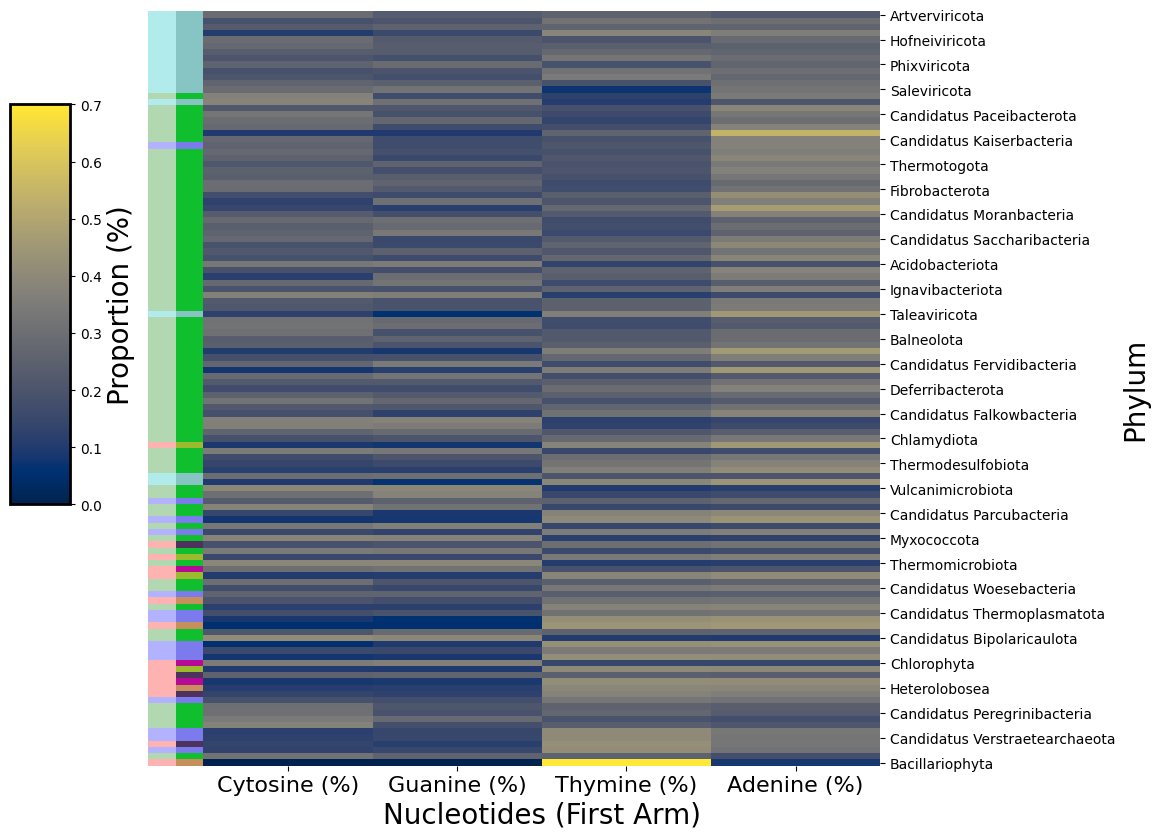

In [35]:
import sys

sys.setrecursionlimit(100000)
cg = sns.clustermap(poly_at_proportions.iloc[:, :4].rename(columns={"c_prop": "Cytosine (%)",
                                                                    "g_prop": "Guanine (%)",
                                                                    "a_prop": "Adenine (%)",
                                                                    "t_prop": "Thymine (%)"
                                                                   }
                                                          ),
                    row_colors=[poly_at_proportions['superkingdom_color'], poly_at_proportions['kingdom_color']], 
                    figsize=(12, 10),
                    # vmax=0.037,
                    vmax=0.7,
                    # vmin=0.00,
                    cmap="cividis", 
                    row_cluster=False,  
                    cbar_kws={"orientation": "vertical",
                              "label": "Proportion (%)"}
            )

x0, _y0, _w, _h = cg.cbar_pos
cg.ax_cbar.set_position([0.05, 0.3, 0.05, 0.4])
# cg.ax_cbar.set_title('Proportion (%)')
cg.ax_cbar.tick_params(axis='x', length=10)
for spine in cg.ax_cbar.spines:
    # g.ax_cbar.spines[spine].set_color('crimson')
    cg.ax_cbar.spines[spine].set_linewidth(2)

cg.ax_row_dendrogram.set_visible(False)
cg.ax_col_dendrogram.set_visible(False)
ax = cg.ax_heatmap
# cbar_axes = ax.figure.axes[-1]
ax.figure.axes[-1].yaxis.label.set_size(20)
# ax.figure.axes[-1].tick_params(axis="both", which="major", labelsize=18)
cg.ax_heatmap.set_xticklabels(cg.ax_heatmap.get_xmajorticklabels(), fontsize = 16)

ax.set_xlabel('Nucleotides (First Arm)')
ax.set_ylabel("Phylum")
ax.yaxis.label.set_size(20)
ax.xaxis.label.set_size(20)

fig.savefig(f"{DATABASE}/primary_arm_nucleotide_phylum_cluster.png", bbox_inches='tight')

In [ ]:
poly_at_proportions.shape

In [ ]:
poly_at_proportions.head(119).tail(50)

In [51]:
decomposed_kmers.head()

,#assembly_accession,a,t,g,at,tg,gt,ta,arm_size,superkingdom,...,ag,gc,ac,cg,cc,gg,gc_content,ta_content,gc_content_prop,ta_content_prop
0,GCF_000002515.2,5,5,1,4,1,1,4,11,Eukaryota,...,0,0,0,0,0,0,1,10,0.090909,0.909091
1,GCF_000002515.2,4,4,2,2,1,0,1,11,Eukaryota,...,0,0,0,0,0,0,3,8,0.272727,0.727273
2,GCF_000002515.2,1,7,0,1,0,0,0,10,Eukaryota,...,0,0,0,0,0,0,2,8,0.200000,0.800000
3,GCF_000002515.2,6,4,2,2,0,0,2,14,Eukaryota,...,2,2,0,0,0,0,4,10,0.285714,0.714286
4,GCF_000002515.2,10,4,6,1,2,2,0,24,Eukaryota,...,3,1,2,1,0,0,10,14,0.416667,0.583333


In [52]:
mononucleotide_decomposition = decomposed_kmers.groupby("#assembly_accession")\
                                            .agg({
                                                    "gc_content": "sum",
                                                    "ta_content": "sum",
                                                    "arm_size": "sum"
                                                })\
                                .apply(lambda row: row/row['arm_size'], axis=1)\
                                .merge(assembly_df[["#assembly_accession", "superkingdom", "genome_size"]], 
                                                       how="left", 
                                                       left_index=True,
                                                       right_on="#assembly_accession")\
                                .set_index("#assembly_accession")
                                
mononucleotide_decomposition

,gc_content,ta_content,arm_size,superkingdom,genome_size
#assembly_accession,,,,,
GCA_000006845.1,0.464690,0.535310,1.0,Bacteria,2153922
GCA_000006865.1,0.265163,0.734837,1.0,Bacteria,2365589
GCA_000006925.2,0.501794,0.498206,1.0,Bacteria,4828820
GCA_000007025.1,0.236735,0.763265,1.0,Bacteria,1268755
GCA_000007085.1,0.383367,0.616633,1.0,Bacteria,2689445
...,...,...,...,...,...
GCF_963422545.1,0.314951,0.685049,1.0,Bacteria,5236164
GCF_963457545.1,0.220548,0.779452,1.0,Archaea,2359279
GCF_963457575.1,0.735236,0.264764,1.0,Bacteria,4103361


In [ ]:
mono_decomposition = decomposed_kmers.groupby(decomposed_kmers.index).agg({
                                                    "a": "sum",
                                                    "t": "sum",
                                                    "c": "sum",
                                                    "g": "sum",
                                                    "arm_size": "sum"
                                                        })\
                                .apply(lambda row: row/row['arm_size'], axis=1)\
                                .merge(assembly_df[["#assembly_accession", "superkingdom", "genome_size"]], 
                                                       how="left", 
                                                       left_index=True,
                                                       right_on="#assembly_accession")\
                                .set_index("#assembly_accession")
                                
mono_decomposition

In [ ]:
decomposed_kmers["AA"] = decomposed_kmers["aa"] + decomposed_kmers["tt"]
decomposed_kmers["GG"] = decomposed_kmers["gg"] + decomposed_kmers["cc"]
decomposed_kmers["GT"] = decomposed_kmers["gt"] + decomposed_kmers["ac"]
decomposed_kmers["CT"] = decomposed_kmers["ct"] + decomposed_kmers["ag"]
decomposed_kmers["TC"] = decomposed_kmers["tc"] + decomposed_kmers["ga"]
decomposed_kmers["CA"] = decomposed_kmers["ca"] + decomposed_kmers["tg"]

In [ ]:
dinucleotide_decomposition = decomposed_kmers.groupby(decomposed_kmers.index)\
                                            .agg({
                                                    "AA": "sum",
                                                    "GG": "sum",
                                                    "GT": "sum",
                                                    "CT": "sum",
                                                    "TC": "sum",
                                                    "CA": "sum",
                                                    "gc": "sum",
                                                    "cg": "sum",
                                                    "ta": "sum",
                                                    "at": "sum",
                                                    "arm_size": "sum"
                                                    })\
                                .apply(lambda row: row/row['arm_size'], axis=1)\
                                .rename(columns={"gc": "GC", "cg": "CG", "ta": "TA", "at": "AT"})\
                                .merge(assembly_df[["#assembly_accession", "genome_size"]], 
                                                       how="left", 
                                                       left_index=True,
                                                       right_on="#assembly_accession")\
                                .set_index("#assembly_accession")
                                
dinucleotide_decomposition

In [ ]:
mononucleotide_decomposition.dropna(subset=['genome_size'], inplace=True)
dinucleotide_decomposition.dropna(subset=['genome_size'], inplace=True)

In [ ]:
mononucleotide_decomposition.shape, dinucleotide_decomposition.shape

In [ ]:
df_segmented = decomposed_kmers.groupby("arm_size", as_index=False)\
                                             .agg({"gc_content": "sum", 
                                                   "ta_content": "sum", 
                                                   "t": "count",
                                                    "superkingdom": "first",
                                                  })\
                                             .rename(columns={"t": "total_counts",
                                                                "gc_content": "gc",
                                                                "ta_content": "ta"})

df_segmented.loc[:, "gc"] = df_segmented["gc"].div(df_segmented["arm_size"]*df_segmented["total_counts"])
df_segmented.loc[:, "ta"] = df_segmented["ta"].div(df_segmented["arm_size"]*df_segmented["total_counts"])
df_segmented.head()

# Global Kmer Counts

In [19]:
def load_kmers(kmer_length):
    jelly_counts = []
    jelly_counts_path = Path("/storage/group/izg5139/default/nicole/inverted_repeats/jellymelly")
    jelly_files = [file for file in jelly_counts_path.joinpath(f"{kmer_length}mers").glob(f"**/*.fasta_{kmer_length}mers") \
                          if '_cds_' not in file.name and '_rna_' not in file.name
                  ]
    
    assert len(jelly_files) > 0, f"Empty jelly extractions at {jelly_counts_path}."
    for file in tqdm(jelly_files, total=len(jelly_files), leave=True, position=0):
        temp = {'filename': '.'.join(file.name.split('.')[:-1])}
        with open(file, "r") as f:
            for line in f:
                nucleotide, count = line.split(" ")
                temp.update({nucleotide: count})
                
        jelly_counts.append(temp)
        
    jelly_counts = pd.DataFrame(jelly_counts).assign(assembly_accession=lambda df: df['filename'].str.extract("(GC[AF]_\d+\.\d+)_"))
    # jelly_counts = jelly_counts[~jelly_counts["filename"].str.contains('_cds_') & ~jelly_counts['filename'].str.contains('_rna_')].reset_index(drop=True)
    
    for col in jelly_counts.columns:
        jelly_counts[col] = jelly_counts[col].str.strip()
        if len(col) <= 2:
            jelly_counts[col] = jelly_counts[col].fillna(0).astype(int)
    
    return jelly_counts

In [20]:
jelly_counts_1mers = load_kmers(1)
jelly_counts_1mers.head()

100%|██████████| 160409/160409 [04:09<00:00, 643.83it/s]


,filename,A,C,G,T,assembly_accession
0,GCA_000006805.1_ASM680v1_genomic,436710,847585,847572,439143,GCA_000006805.1
1,GCA_000007005.1_ASM700v1_genomic,955581,534131,536709,965824,GCA_000007005.1
2,GCA_000007065.1_ASM706v1_genomic,1201032,849008,850357,1195948,GCA_000007065.1
3,GCA_000007185.1_ASM718v1_genomic,329926,520760,515869,328414,GCA_000007185.1
4,GCA_000007225.1_ASM722v1_genomic,544397,564917,576579,536537,GCA_000007225.1


In [21]:
jelly_counts_1mers.isna().sum().sum()

0

In [22]:
jelly_counts_2mers = load_kmers(2)
jelly_counts_2mers.head()

100%|██████████| 160409/160409 [04:14<00:00, 630.02it/s]


,filename,AA,AC,AG,AT,CA,CC,CG,CT,GA,GC,GG,GT,TA,TC,TG,TT,assembly_accession
0,GCA_000006805.1_ASM680v1_genomic,70179,175088,117170,74270,131856,218495,379087,118147,191368,261515,218880,175809,43307,192487,132433,70916,GCA_000006805.1
1,GCA_000007005.1_ASM700v1_genomic,316332,144419,200835,293994,150371,118445,64227,201088,179052,90598,119830,147229,309826,180669,151816,323513,GCA_000007005.1
2,GCA_000007065.1_ASM706v1_genomic,423848,184580,265270,327334,247387,210330,126109,265182,271738,184610,209718,184291,258059,269488,249259,419141,GCA_000007065.1
3,GCA_000007185.1_ASM718v1_genomic,59026,111457,98501,60942,80853,153805,186947,99155,136946,117602,151600,109720,53101,137896,78820,58597,GCA_000007185.1
4,GCA_000007225.1_ASM722v1_genomic,155801,115343,151213,122040,117795,158242,142643,146236,129095,168773,163636,115075,141706,122559,119086,153186,GCA_000007225.1


In [23]:
jelly_counts_2mers.isna().sum().sum()

0

In [29]:
assembly_df = irp_df[["#assembly_accession", "genome_size", "gc_percent", "phylum", "kingdom", "superkingdom"]].drop_duplicates()

In [30]:
merged_jelly_counts = assembly_df\
                    .merge(jelly_counts_1mers, left_on="#assembly_accession", 
                                               right_on="assembly_accession", 
                                               how="inner", 
                           suffixes=("", "_x")
                          )\
                    .merge(jelly_counts_2mers, 
                           left_on="#assembly_accession", 
                           right_on="assembly_accession", 
                           how="left", 
                           suffixes=("", "_y")
                          )

merged_jelly_counts

,#assembly_accession,genome_size,gc_percent,phylum,kingdom,superkingdom,filename,A,C,G,...,CT,GA,GC,GG,GT,TA,TC,TG,TT,assembly_accession_y
0,GCF_000002515.2,10689156,38.5,Ascomycota,Fungi,Eukaryota,GCF_000002515.2_ASM251v1_genomic,3287733,2079979,2074078,...,635400,713800,366725,406223,587326,746572,715081,722920,1103036,GCF_000002515.2
1,GCF_000002725.2,32855089,59.5,Euglenozoa,Protista,Eukaryota,GCF_000002725.2_ASM272v2_genomic,6560443,9852861,9768106,...,2126964,2053568,3390395,2318901,2005230,739139,2108650,2401122,1424746,GCF_000002725.2
2,GCF_000005825.2,4249248,39.5,Bacillota,Eubacteria,Bacteria,GCF_000005825.2_ASM582v2_genomic,1264612,854922,838852,...,265664,262529,202150,165418,208754,303882,274118,270882,441979,GCF_000005825.2
3,GCF_000005845.2,4641652,50.5,Pseudomonadota,Eubacteria,Bacteria,GCF_000005845.2_ASM584v2_genomic,1142742,1180091,1177437,...,236149,267384,384102,270252,255699,212024,267395,322379,339584,GCF_000005845.2
4,GCF_000006605.1,2476822,61.0,Actinomycetota,Eubacteria,Bacteria,GCF_000006605.1_ASM660v1_genomic,475557,762548,757016,...,142658,154552,253473,209216,139775,59418,160192,159587,102503,GCF_000006605.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76953,GCF_963378075.1,4341397,68.5,Actinomycetota,Eubacteria,Bacteria,GCF_963378075.1_MU0083_Flye_MinION_genomic,680421,1496175,1483575,...,184127,274375,510724,437908,260567,53120,274593,252303,101210,GCF_963378075.1
76954,GCF_963378085.1,5224726,68.5,Actinomycetota,Eubacteria,Bacteria,GCF_963378085.1_MU0050_Flye_MinION_genomic,821114,1796039,1789651,...,232014,337353,622642,523906,305750,57058,337760,301309,121794,GCF_963378085.1
76955,GCF_963378105.1,4794172,67.0,Actinomycetota,Eubacteria,Bacteria,GCF_963378105.1_MU0102_Flye_MinION_genomic,779733,1626894,1608398,...,218835,300004,567999,459935,280459,63123,300622,292123,123279,GCF_963378105.1
76956,GCF_963422545.1,5236164,33.0,Bacteroidota,Eubacteria,Bacteria,GCF_963422545.1_odEunFrag1.Flavobacterium_sp_1...,1746691,875557,874797,...,262410,287977,181730,162610,242474,428100,288149,307153,715700,GCF_963422545.1


In [31]:
merged_jelly_counts.isna().sum().sum()

3838

In [32]:
for col in merged_jelly_counts.columns:
    if len(col) <= 2:
        merged_jelly_counts.loc[:, col] = merged_jelly_counts[col].astype(int)

In [33]:
merged_jelly_counts.loc[:, "AA_jelly"] = merged_jelly_counts["AA"] + merged_jelly_counts["TT"]
merged_jelly_counts.loc[:, "GG_jelly"] = merged_jelly_counts["GG"] + merged_jelly_counts["CC"]
merged_jelly_counts.loc[:, "GT_jelly"] = merged_jelly_counts["GT"] + merged_jelly_counts["AC"]
merged_jelly_counts.loc[:, "CT_jelly"] = merged_jelly_counts["CT"] + merged_jelly_counts["AG"]
merged_jelly_counts.loc[:, "TC_jelly"] = merged_jelly_counts["TC"] + merged_jelly_counts["GA"]
merged_jelly_counts.loc[:, "CA_jelly"] = merged_jelly_counts["CA"] + merged_jelly_counts["TG"]

In [54]:
full_genome_nucleotide_counts = merged_jelly_counts[["A", 
                                                    "G", 
                                                    "C", 
                                                    "T", 
                                                    "AA_jelly", 
                                                    "GG_jelly", 
                                                    "GT_jelly", 
                                                    "CT_jelly", 
                                                    "TC_jelly",
                                                    "CA_jelly",
                                                    "TA",
                                                    "AT",
                                                    "GC",
                                                    "CG",
                                                    "genome_size", 
                                                    "#assembly_accession"]]\
                                    .set_index("#assembly_accession")\
                                    .apply(lambda row: row/row['genome_size'], axis=1)\
                                    .drop(columns=["genome_size"])\
                                    .assign(_type="jelly_melly")

full_genome_nucleotide_counts = full_genome_nucleotide_counts[full_genome_nucleotide_counts.index.isin(set(mononucleotide_decomposition.index))]\
                                    .sort_index()\
                                    .rename(columns={
                                                     "AA_jelly": "AA", 
                                                     "GG_jelly": "GG", 
                                                     "GT_jelly": "GT", 
                                                     "CT_jelly": "CT", 
                                                     "TC_jelly": "TC", 
                                                     "CA_jelly": "CA"
                                                    })

full_genome_nucleotide_counts

,A,G,C,T,AA,GG,GT,CT,TC,CA,TA,AT,GC,CG,_type
#assembly_accession,,,,,,,,,,,,,,,
GCA_000006845.1,0.235117,0.263838,0.263059,0.237987,0.167095,0.134587,0.103821,0.083552,0.111400,0.124287,0.035161,0.059318,0.088544,0.092235,jelly_melly
GCA_000006865.1,0.323773,0.177752,0.175542,0.322933,0.257496,0.065812,0.093898,0.110346,0.119453,0.128783,0.070487,0.092483,0.037065,0.024177,jelly_melly
GCA_000006925.2,0.247076,0.252613,0.253931,0.246379,0.145141,0.116474,0.111351,0.104389,0.116388,0.140259,0.045833,0.066287,0.081165,0.072711,jelly_melly
GCA_000007025.1,0.336807,0.163221,0.161167,0.338805,0.252289,0.057582,0.089166,0.112811,0.098389,0.099958,0.112487,0.110673,0.039625,0.027019,jelly_melly
GCA_000007085.1,0.311557,0.187646,0.188063,0.312734,0.230864,0.086986,0.088075,0.135593,0.117802,0.116462,0.079581,0.084880,0.041423,0.018334,jelly_melly
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GCF_963422545.1,0.333582,0.167068,0.167213,0.332136,0.274563,0.061896,0.092942,0.100155,0.110028,0.117605,0.081758,0.099027,0.034707,0.027312,jelly_melly
GCF_963457545.1,0.320138,0.176803,0.177953,0.325107,0.238163,0.066348,0.096296,0.112312,0.129395,0.142644,0.067521,0.099237,0.031359,0.016726,jelly_melly
GCF_963457575.1,0.167264,0.329372,0.336849,0.166515,0.061166,0.194348,0.097068,0.096273,0.136005,0.112152,0.012224,0.039633,0.119395,0.131718,jelly_melly


In [55]:
full_genome_nucleotide_counts.loc[:, "gc_content"] = full_genome_nucleotide_counts["G"] + full_genome_nucleotide_counts["C"]
full_genome_nucleotide_counts.loc[:, "ta_content"] = full_genome_nucleotide_counts["T"] + full_genome_nucleotide_counts["A"]
full_genome_nucleotide_counts

,A,G,C,T,AA,GG,GT,CT,TC,CA,TA,AT,GC,CG,_type,gc_content,ta_content
#assembly_accession,,,,,,,,,,,,,,,,,
GCA_000006845.1,0.235117,0.263838,0.263059,0.237987,0.167095,0.134587,0.103821,0.083552,0.111400,0.124287,0.035161,0.059318,0.088544,0.092235,jelly_melly,0.526897,0.473103
GCA_000006865.1,0.323773,0.177752,0.175542,0.322933,0.257496,0.065812,0.093898,0.110346,0.119453,0.128783,0.070487,0.092483,0.037065,0.024177,jelly_melly,0.353294,0.646706
GCA_000006925.2,0.247076,0.252613,0.253931,0.246379,0.145141,0.116474,0.111351,0.104389,0.116388,0.140259,0.045833,0.066287,0.081165,0.072711,jelly_melly,0.506544,0.493455
GCA_000007025.1,0.336807,0.163221,0.161167,0.338805,0.252289,0.057582,0.089166,0.112811,0.098389,0.099958,0.112487,0.110673,0.039625,0.027019,jelly_melly,0.324388,0.675612
GCA_000007085.1,0.311557,0.187646,0.188063,0.312734,0.230864,0.086986,0.088075,0.135593,0.117802,0.116462,0.079581,0.084880,0.041423,0.018334,jelly_melly,0.375709,0.624291
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GCF_963422545.1,0.333582,0.167068,0.167213,0.332136,0.274563,0.061896,0.092942,0.100155,0.110028,0.117605,0.081758,0.099027,0.034707,0.027312,jelly_melly,0.334282,0.665718
GCF_963457545.1,0.320138,0.176803,0.177953,0.325107,0.238163,0.066348,0.096296,0.112312,0.129395,0.142644,0.067521,0.099237,0.031359,0.016726,jelly_melly,0.354756,0.645244
GCF_963457575.1,0.167264,0.329372,0.336849,0.166515,0.061166,0.194348,0.097068,0.096273,0.136005,0.112152,0.012224,0.039633,0.119395,0.131718,jelly_melly,0.666221,0.333779


In [56]:
mononucleotide_decomposition = mononucleotide_decomposition.assign(_type="irp_pie").sort_index()


nucleotides_comparison = pd.concat([
                                    mononucleotide_decomposition[["gc_content", "ta_content", "_type"]], 
                                    full_genome_nucleotide_counts[["gc_content", "ta_content", "_type"]]
                                   ], 
                                   axis=0)
print(nucleotides_comparison.shape)
print(nucleotides_comparison.isna().sum())
nucleotides_comparison

(153782, 3)
gc_content    0
ta_content    0
_type         0
dtype: int64


,gc_content,ta_content,_type
#assembly_accession,,,
GCA_000006845.1,0.464690,0.535310,irp_pie
GCA_000006865.1,0.265163,0.734837,irp_pie
GCA_000006925.2,0.501794,0.498206,irp_pie
GCA_000007025.1,0.236735,0.763265,irp_pie
GCA_000007085.1,0.383367,0.616633,irp_pie
...,...,...,...
GCF_963422545.1,0.334282,0.665718,jelly_melly
GCF_963457545.1,0.354756,0.645244,jelly_melly
GCF_963457575.1,0.666221,0.333779,jelly_melly


In [57]:
nucleotides_comparison = nucleotides_comparison\
                            .merge(assembly_df[["#assembly_accession", "superkingdom"]], 
                                   left_index=True, 
                                   right_on="#assembly_accession")\
                            .set_index("#assembly_accession")
nucleotides_comparison = nucleotides_comparison[nucleotides_comparison['superkingdom'].isin(domains)]
nucleotides_comparison

,gc_content,ta_content,_type,superkingdom
#assembly_accession,,,,
GCA_000006845.1,0.464690,0.535310,irp_pie,Bacteria
GCA_000006845.1,0.526897,0.473103,jelly_melly,Bacteria
GCA_000006865.1,0.265163,0.734837,irp_pie,Bacteria
GCA_000006865.1,0.353294,0.646706,jelly_melly,Bacteria
GCA_000006925.2,0.501794,0.498206,irp_pie,Bacteria
...,...,...,...,...
GCF_963457575.1,0.666221,0.333779,jelly_melly,Bacteria
GCF_963457595.1,0.397083,0.602917,irp_pie,Bacteria
GCF_963457595.1,0.420299,0.579701,jelly_melly,Bacteria


In [71]:
!echo ${DATABASE}/gc_ta_content_domain_comparison.png

$/storage/group/izg5139/default/nicole/inverted_repeats/paper_graphs/final_figures/gc_ta_content_domain_comparison.png


  0%|          | 0/4 [00:00<?, ?it/s]/storage/group/izg5139/default/nicole/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/storage/group/izg5139/default/nicole/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/storage/group/izg5139/default/nicole/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/storage/group/izg5139/default/nicole/miniconda3/lib/python3.11/site-packages/seaborn/_old

Archaea
Eukaryota
Bacteria


/storage/group/izg5139/default/nicole/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
 75%|███████▌  | 3/4 [00:00<00:00, 10.70it/s]/storage/group/izg5139/default/nicole/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/storage/group/izg5139/default/nicole/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/storage/group/izg5139/default/nicole/miniconda3/lib/python3.11/site-packages/seab

Viruses


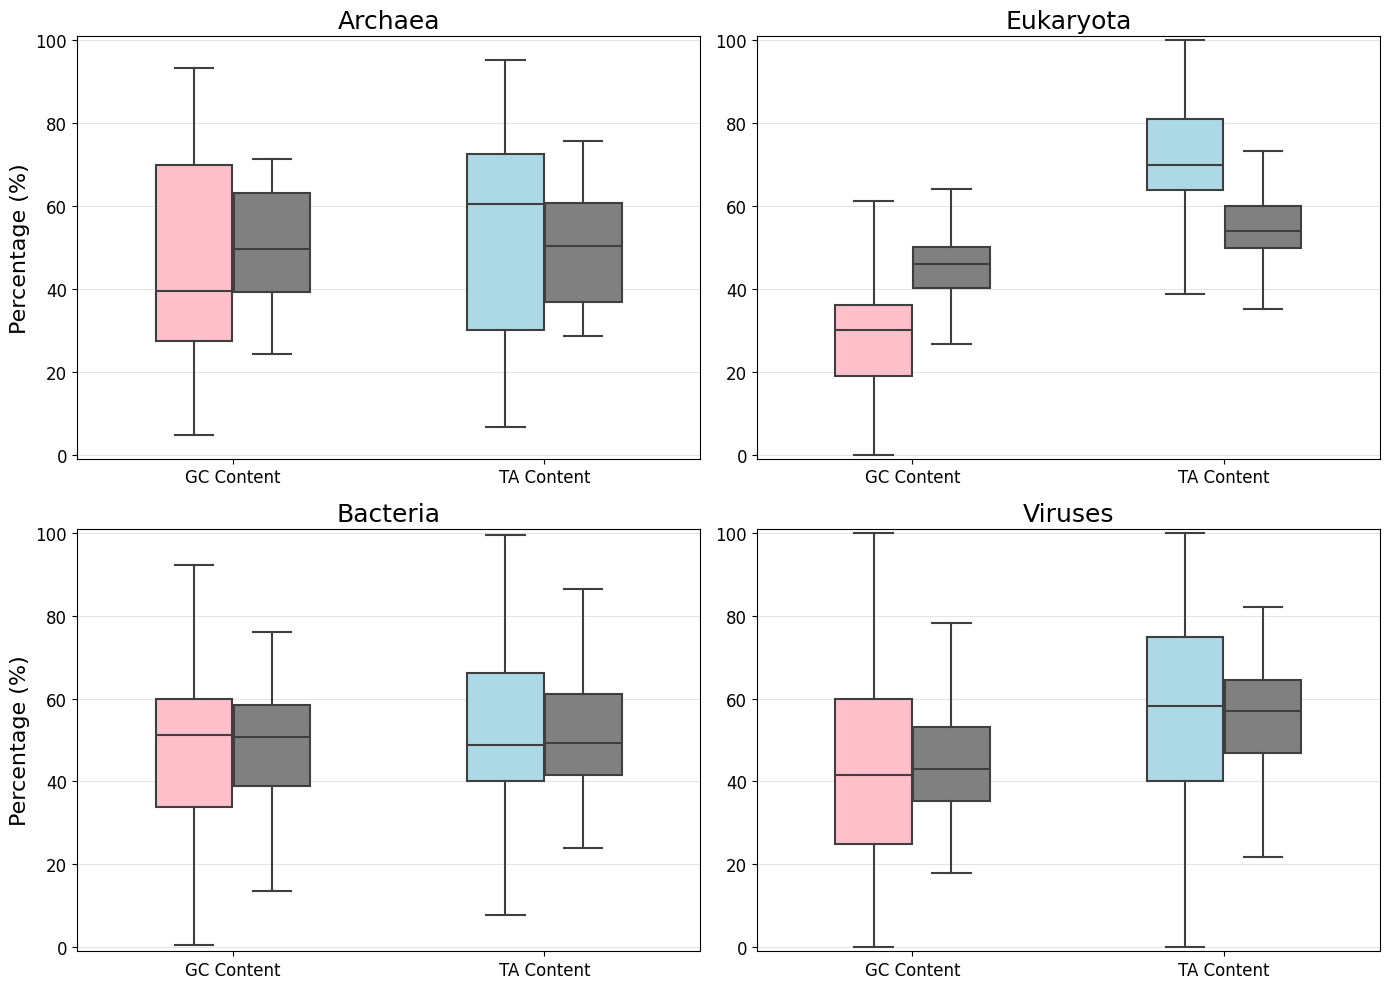

In [76]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
axes = [ax[0][0], ax[0][1], ax[1][0], ax[1][1]]


for index, superkingdom in tqdm(enumerate(["Archaea", "Eukaryota", "Bacteria", "Viruses"]), total=4):
    print(superkingdom)
    temp = nucleotides_comparison[nucleotides_comparison["superkingdom"] == superkingdom]
    mononucleotides_comparison_melted = pd.melt(temp[["gc_content", "ta_content", "_type"]], 
                                                "_type", 
                                               var_name="Nucleotide", 
                                               value_name="Proportion"
                                           )
    mononucleotides_comparison_melted["_type"] = mononucleotides_comparison_melted["_type"].str.replace("irp_pie", "IR")\
                                                                                           .str.replace("jelly_melly", "Genome") 
    ax_ = axes[index]
    ax_.grid(lw=0.4, alpha=0.6, zorder=0)
    ax_.set_axisbelow(True)
    sns.boxplot(data=mononucleotides_comparison_melted.assign(Proportion=lambda df: df['Proportion'] * 100), 
                x="Nucleotide", 
                y="Proportion", 
                hue="_type", 
                ax=ax_, 
                showfliers=False, 
                width=0.5,
                zorder=3, 
                boxprops=dict(alpha=1.0),
            )

    import matplotlib.patches
    boxes = ax_.findobj(matplotlib.patches.PathPatch)
    colors = ["pink", "gray", "lightblue", "gray"]
    for color, box in zip(colors, boxes):
        box.set_facecolor(color)

    if index == 1 or index == 3:
        ax_.set_ylabel("")
    else:
        ax_.set_ylabel("Percentage (%)")
        
    ax_.set_xlabel("")
        
    ax_.set_xticks(range(2), ["GC Content", "TA Content"])
    ax_.yaxis.label.set_size(16)
    ax_.xaxis.label.set_size(16)
    ax_.set_ylim(-1, 101)
    ax_.tick_params(which="major", axis="both", labelsize=12)
    ax_.legend(handles=[], frameon=False, fancybox=False)
    ax_.set_title(superkingdom)
    ax_.title.set_size(18)
    
    # annotator = Annotator(ax_, pairs, **hue_plot_params)
    # annotator.configure(test="Mann-Whitney").apply_and_annotate()
    
    
plt.tight_layout()
    # ax_.legend(bbox_to_anchor=(1.15, 0.7), frameon=True, fancybox=True, title="Type")
fig.savefig(f"{DATABASE}/gc_ta_content_domain_comparison.png", bbox_inches='tight')
fig.savefig(f"{DATABASE}/gc_ta_content_domain_comparison.pdf", bbox_inches='tight', format="pdf")